# In this notebook we explore how dimensionality of the embeddings affects the results

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler


import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transform
from torchvision.transforms import ToTensor

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import matplotlib.pyplot as plt
import glob
import os
import sys
import numpy as np

import subprocess
import glob
from moviepy.editor import VideoFileClip

from torch.utils.data import Dataset
from torch.utils.data.sampler import BatchSampler

from PIL import Image
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score

In [22]:
# We use CUDA if possible
cuda = torch.cuda.is_available()
print("CUDA is available:", cuda)
device = torch.device('cuda' if cuda else 'cpu')

CUDA is available: True


### First we create the dataset

Implementation made following https://github.com/adambielski/siamese-triplet

In [23]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
    
        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        if self.train:
            self.train_labels = self.mnist_dataset.train_labels
            self.train_data = self.mnist_dataset.train_data
            self.labels_set = set(self.train_labels.numpy())
            self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                     for label in self.labels_set}
        else:
            # generate fixed pairs for testing
            self.test_labels = self.mnist_dataset.test_labels
            self.test_data = self.mnist_dataset.test_data
            self.labels_set = set(self.test_labels.numpy())
            self.label_to_indices = {label: np.where(self.test_labels.numpy() == label)[0]
                                     for label in self.labels_set}

            random_state = np.random.RandomState(29)

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.test_labels[i].item()]),
                               1]
                              for i in range(0, len(self.test_data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.test_labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.test_data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            target = np.random.randint(0, 2)
            img1, label1 = self.train_data[index], self.train_labels[index].item()
            if target == 1:
                siamese_index = index
                while siamese_index == index:
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else:
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.train_data[siamese_index]
        else:
            img1 = self.test_data[self.test_pairs[index][0]]
            img2 = self.test_data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]
        
        if len(img1.shape) > 2:
            img1 = Image.fromarray(np.uint8(img1.permute(1, 2, 0).numpy() * 255))
            img2 = Image.fromarray(np.uint8(img2.permute(1, 2, 0).numpy() * 255))
        else:
            # In the case of the MNIST dataset image was already in range [0-255]
            img1 = Image.fromarray(img1.numpy(), mode='L')
            img2 = Image.fromarray(img2.numpy(), mode='L')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return (img1, img2), target

    def __len__(self):
        return len(self.mnist_dataset)
    
### HYPERPARAMETERS
train_set = 'MIT_SPLIT'

print('Training set is:', train_set)
root_dir = '../datasets/' + train_set

train_data_dir= root_dir + '/train'
val_data_dir= root_dir + '/test'
test_data_dir= root_dir + '/test'

img_width = 224
img_height=224


### CREATE DATASET
transformation_train = transform.Compose([
    # you can add other transformations in this list
    # transform.RandomRotation(90),
    # transform.RandomHorizontalFlip(),
    # transform.RandomVerticalFlip(),
    ToTensor()
])

# No need to use data augmentation in validation
transformation_val = transform.Compose([
    # you can add other transformations in this list
    ToTensor()
])

batch_size = 8

train_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transformation_train)
valid_dataset = torchvision.datasets.ImageFolder(root=test_data_dir,  transform=transformation_val)

original_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
original_test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# We need to fill some attributes for the SiameseDataset class
train_dataset.train = True
valid_dataset.train = False

train_dataset.train_labels = torch.from_numpy(np.array(train_dataset.targets))
valid_dataset.test_labels = torch.from_numpy(np.array(valid_dataset.targets))

train_dataset.train_data = torch.from_numpy(np.array([s[0].numpy() for s in train_dataset]))
valid_dataset.test_data = torch.from_numpy(np.array([s[0].numpy() for s in valid_dataset]))


inv_class_to_idx = {v: k for k, v in train_dataset.class_to_idx.items()}

print(train_dataset.class_to_idx)
print(train_dataset.train_data.shape)
print(train_dataset.train_labels.shape)

siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(valid_dataset)

siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

Training set is: MIT_SPLIT
{'Opencountry': 0, 'coast': 1, 'forest': 2, 'highway': 3, 'inside_city': 4, 'mountain': 5, 'street': 6, 'tallbuilding': 7}
torch.Size([1881, 3, 256, 256])
torch.Size([1881])


In [24]:
mnist_classes = train_dataset.classes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

def plot_embeddings(embeddings, targets, title='', save_name='', xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    plt.title(title)
    for i in range(8):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes, loc="upper right")
    if save_name != '':
        plt.savefig(f'./outputs_task_b/{save_name}')
        plt.close()

### Now we create our Siamese Neural Network

In [25]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [26]:
dimensionalities = [2, 256, 1024, 8192, 65536]
maps = []
prec1_alls = []
prec5_alls = []

for dimensionality in dimensionalities:
    def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
            start_epoch=0, save_gif=False):
        """
        Loaders, model, loss function and metrics should work together for a given task,
        i.e. The model should be able to process data output of loaders,
        loss function should process target output of loaders and outputs from the model
        Examples: Classification: batch loader, classification model, NLL loss, accuracy metric
        Siamese network: Siamese loader, siamese model, contrastive loss
        Online triplet learning: batch loader, embedding model, online triplet loss
        """
        train_losses = []
        val_losses = []
        
        for epoch in range(0, start_epoch):
            scheduler.step()

        for epoch in range(start_epoch, n_epochs):
            scheduler.step()

            # Train stage
            train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)
            message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())
            
            # Test stage
            val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
            val_loss /= len(val_loader)
            
            train_losses.append(train_loss)
            val_losses.append(val_loss)

            message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                    val_loss)
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            
        if save_gif:
            train_embeddings_cl, train_labels_cl = extract_embeddings(original_train_loader, model)
            val_embeddings_cl, val_labels_cl = extract_embeddings(original_test_loader, model)
            
            for dim_reduction in ['umap']:
                plot_embeddings(train_embeddings_cl, train_labels_cl, title='Train embeddings', save_name=f'train_embedding_{dimensionality}_{dim_reduction}_{str(epoch).zfill(3)}.png')
                plot_embeddings(val_embeddings_cl, val_labels_cl, title='Test embeddings', save_name=f'test_embedding_{dimensionality}_{dim_reduction}_{str(epoch).zfill(3)}.png')
        
        return train_losses, val_losses


    def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
        for metric in metrics:
            metric.reset()

        model.train()

        losses = []
        total_loss = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()


            optimizer.zero_grad()
            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)

            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            losses.append(loss.item())
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

            if batch_idx % log_interval == 0:
                message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    batch_idx * len(data[0]), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), np.mean(losses))
                for metric in metrics:
                    message += '\t{}: {}'.format(metric.name(), metric.value())

                print(message)
                losses = []

        total_loss /= (batch_idx + 1)
        return total_loss, metrics


    def test_epoch(val_loader, model, loss_fn, cuda, metrics):
        with torch.no_grad():
            for metric in metrics:
                metric.reset()
            model.eval()
            val_loss = 0
            for batch_idx, (data, target) in enumerate(val_loader):
                target = target if len(target) > 0 else None
                if not type(data) in (tuple, list):
                    data = (data,)
                if cuda:
                    data = tuple(d.cuda() for d in data)
                    if target is not None:
                        target = target.cuda()

                outputs = model(*data)

                if type(outputs) not in (tuple, list):
                    outputs = (outputs,)
                loss_inputs = outputs
                if target is not None:
                    target = (target,)
                    loss_inputs += target

                loss_outputs = loss_fn(*loss_inputs)
                loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
                val_loss += loss.item()

                for metric in metrics:
                    metric(outputs, target, loss_outputs)

        return val_loss, metrics


    class EmbeddingNet(nn.Module):
        def __init__(self):
            super(EmbeddingNet, self).__init__()
            # Change for one channel instead of 3 if input is grayscale
            self.convnet = nn.Sequential(nn.Conv2d(3, 32, 5), nn.PReLU(),
                                        nn.MaxPool2d(2, stride=2),
                                        nn.Conv2d(32, 64, 5), nn.PReLU(),
                                        nn.MaxPool2d(2, stride=2))

            self.fc = nn.Sequential(nn.Linear(238144, 256),
                                    nn.PReLU(),
                                    nn.Linear(256, 256),
                                    nn.PReLU(),
                                    nn.Linear(256, dimensionality)
                                    )

        def forward(self, x):
            output = self.convnet(x)
            output = output.view(output.size()[0], -1)
            output = self.fc(output)
            return output

        def get_embedding(self, x):
            return self.forward(x)
        
    class SiameseNet(nn.Module):
        def __init__(self, embedding_net):
            super(SiameseNet, self).__init__()
            self.embedding_net = embedding_net
            
        def forward(self, x1, x2):
            output1 = self.embedding_net(x1)
            output2 = self.embedding_net(x2)
            
            return output1, output2

        def get_embedding(self, x):
            return self.embedding_net(x)

    def extract_embeddings(dataloader, model):
        with torch.no_grad():
            model.eval()
            embeddings = np.zeros((len(dataloader.dataset), dimensionality))
            labels = np.zeros(len(dataloader.dataset))
            k = 0
            for images, target in dataloader:
                if cuda:
                    images = images.cuda()
                embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
                labels[k:k+len(images)] = target.numpy()
                k += len(images)
        
        return embeddings, labels

    def plot_embeddings(embeddings, targets, title='', save_name='', xlim=None, ylim=None, dim_reduction='pca'):
        if embeddings.shape[1] > 2:
            if dim_reduction == 'pca':
                pca = PCA(n_components=2)
                embeddings = pca.fit_transform(embeddings)
            elif dim_reduction == 'tsne':
                embeddings = TSNE(n_components=2).fit_transform(embeddings)
            elif dim_reduction == 'umap':
                embeddings = umap.UMAP().fit_transform(embeddings)
        
        plt.figure(figsize=(10,10))
        plt.title(title)
        for i in range(8):
            inds = np.where(targets==i)[0]
            plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
        if xlim:
            plt.xlim(xlim[0], xlim[1])
        if ylim:
            plt.ylim(ylim[0], ylim[1])
        plt.legend(mnist_classes, loc="upper right")
        if save_name != '':
            plt.savefig(f'./outputs_task_b/{save_name}')
            plt.close()

    margin = 1.
    embedding_net = EmbeddingNet()
    model = SiameseNet(embedding_net)
    if cuda:
        model.cuda()
    loss_fn = ContrastiveLoss(margin)
    lr = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
    n_epochs = 30
    log_interval = 100

    train_losses, val_losses = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, save_gif=True)

    # storing the image representations
    im_indices = []
    im_representations = []
    embeddings_indexed = []
    labels_indexed = []

    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(original_train_loader):
            data, labels = data.to(device), labels.to(device)
            embeddings = model.get_embedding(data).cpu().numpy()
            
            for idx, (im, label) in enumerate(zip(data, labels)):
                im = im.permute(0, 1, 2).cpu().numpy()
                label = label.cpu().numpy()
                embedding = embeddings[idx]
                im_indices.append(mnist_classes[label])
                im_representations.append(im)
                embeddings_indexed.append(embedding)
                labels_indexed.append(label)
                
    embeddings_indexed = np.array(embeddings_indexed)
    labels_indexed = np.array(labels_indexed)

    knn = KNeighborsClassifier(n_neighbors=5).fit(embeddings_indexed, labels_indexed)

    model.eval()  # Set model to evaluation mode


    test_embeddings, test_labels = extract_embeddings(original_test_loader, model)
    train_embeddings, train_labels = extract_embeddings(original_train_loader, model) 


    k = 10 # number of neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_embeddings, train_labels)
    distances, indices = knn.kneighbors(test_embeddings)

    labels_train = train_labels
    labels_val = test_labels

    val_targets = np.uint8(labels_val)
    train_targets = np.uint8(labels_train)

    # Compute the evaluation metrics
    APs = []
    Precisions_at_1 = []
    Precisions_at_5 = []

    # Compute MAP
    # Convert integer targets to binary targets
    binary_val_targets = np.zeros((test_embeddings.shape[0], 8))
    binary_val_targets[np.arange(test_embeddings.shape[0]), val_targets] = 1

    binary_train_targets = np.zeros((test_embeddings.shape[0], 8))
    binary_train_targets[np.arange(test_embeddings.shape[0])[:,None], train_targets[indices]] = 1

    # Compute average precision 
    for i in range(test_embeddings.shape[0]):
        AP = average_precision_score(binary_val_targets[i], binary_train_targets[i])
        APs.append(AP)

    MAP = np.mean(APs)

    for i, (dists, idxs, target) in enumerate(zip(distances, indices, val_targets)):
        # Compute the precision at 1
        if train_targets[idxs[0]] == target:
            Precisions_at_1.append(1.0)
        else:
            Precisions_at_1.append(0.0)

        # Compute the precision at 5
        Precisions_at_5 = []
        for idx, target in zip(indices, val_targets):
            hits = np.isin(train_targets[idx][:5], target)
            precision_at_5 = np.sum(hits) / 5.0
            Precisions_at_5.append(precision_at_5)

    # Compute the precision at 1 and precision at 5
    Prec_1 = np.mean(Precisions_at_1)
    Prec_5 = np.mean(Precisions_at_5)

    maps.append(MAP)
    prec1_alls.append(Prec_1)
    prec5_alls.append(Prec_5)

Train: [0/1881 (0%)]	Loss: 0.246699
Train: [800/1881 (42%)]	Loss: 0.147226
Train: [1600/1881 (85%)]	Loss: 0.124329
Epoch: 1/30. Train set: Average loss: 0.1347
Epoch: 1/30. Validation set: Average loss: 0.1296
Train: [0/1881 (0%)]	Loss: 0.059445
Train: [800/1881 (42%)]	Loss: 0.120591
Train: [1600/1881 (85%)]	Loss: 0.123343
Epoch: 2/30. Train set: Average loss: 0.1216
Epoch: 2/30. Validation set: Average loss: 0.1271
Train: [0/1881 (0%)]	Loss: 0.094988
Train: [800/1881 (42%)]	Loss: 0.116766
Train: [1600/1881 (85%)]	Loss: 0.116564
Epoch: 3/30. Train set: Average loss: 0.1149
Epoch: 3/30. Validation set: Average loss: 0.1151
Train: [0/1881 (0%)]	Loss: 0.072679
Train: [800/1881 (42%)]	Loss: 0.115529
Train: [1600/1881 (85%)]	Loss: 0.108124
Epoch: 4/30. Train set: Average loss: 0.1115
Epoch: 4/30. Validation set: Average loss: 0.1145
Train: [0/1881 (0%)]	Loss: 0.061500
Train: [800/1881 (42%)]	Loss: 0.103319
Train: [1600/1881 (85%)]	Loss: 0.100663
Epoch: 5/30. Train set: Average loss: 0.1017


In [29]:
print(maps)
print(prec1_alls)
print(prec5_alls)

[0.46980586534489877, 0.6735336637752994, 0.6444547707558861, 0.6185357290375877, 0.5908199091284593]
[0.5105328376703842, 0.6914498141263941, 0.7125154894671624, 0.6728624535315985, 0.6406443618339529]
[0.5102850061957869, 0.6855018587360595, 0.7028500619578686, 0.6619578686493185, 0.626270136307311]


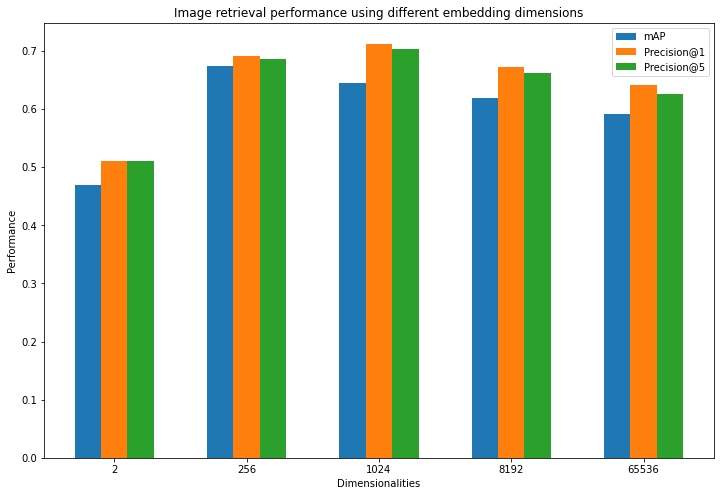

In [37]:
# Plotting
fig, ax = plt.subplots(figsize=(12,8))
x = range(len(maps))
width = 0.2
ax.bar(x, maps, width, label='mAP')
ax.bar([i+width for i in x], prec1_alls, width, label='Precision@1')
ax.bar([i+width*2 for i in x], prec5_alls, width, label='Precision@5')

ax.set_xticks([i + width for i in x])
ax.set_xticklabels([2, 256, 1024, 8192, 65536])

# Axis labels and title
ax.set_xlabel('Dimensionalities')
ax.set_ylabel('Performance')
ax.set_title('Image retrieval performance using different embedding dimensions')

# Legend
ax.legend()

plt.show()

In [39]:
losses_fn = [0, 0.5, 1, 2, 5, 20, 50]
maps = [0.16719183336283705, 0.445518380834366, 0.42778810408921936, 0.49951466336224704, 0.41368236266005787, 0.375784799669558, 0.3417625538443383]
prec1_alls = [0.13135068153655513, 0.49566294919454773, 0.46220570012391576, 0.5390334572490706, 0.45848822800495664, 0.4485749690210657, 0.4200743494423792]
prec5_alls = [0.14671623296158612, 0.49516728624535317, 0.46617100371747217, 0.5531598513011152, 0.4703841387856258, 0.45204460966542753, 0.4096654275092937]

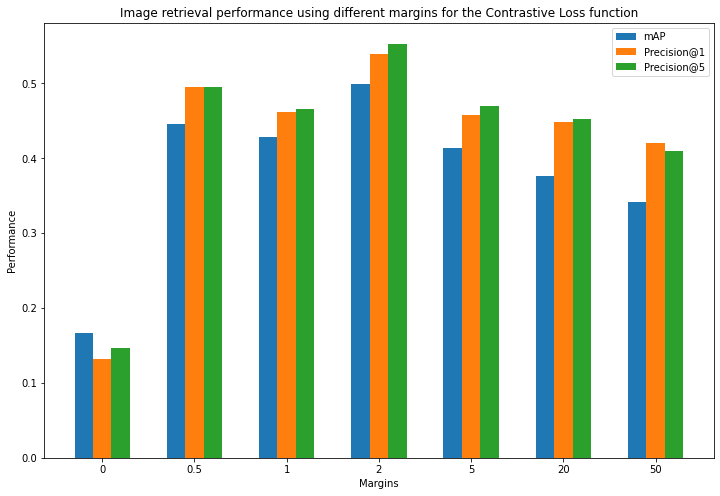

In [40]:
# Plotting
fig, ax = plt.subplots(figsize=(12,8))
x = range(len(maps))
width = 0.2
ax.bar(x, maps, width, label='mAP')
ax.bar([i+width for i in x], prec1_alls, width, label='Precision@1')
ax.bar([i+width*2 for i in x], prec5_alls, width, label='Precision@5')

ax.set_xticks([i + width for i in x])
ax.set_xticklabels(losses_fn)

# Axis labels and title
ax.set_xlabel('Margins')
ax.set_ylabel('Performance')
ax.set_title('Image retrieval performance using different margins for the Contrastive Loss function')

# Legend
ax.legend()

plt.show()